In [1]:
# a = []
# pickle.dump(a,open('../train/vgg/'+"dirty"+'/processed_files.pickle',"wb"))
# pickle.dump(a,open('../train/vgg/'+"clean"+'/processed_files.pickle',"wb"))

# a = np.array(a)
# pickle.dump(a,open('../train/vgg/clean/preprocessed.pickle',"wb"))
# pickle.dump(a,open('../train/vgg/dirty/preprocessed.pickle',"wb"))

In [1]:
# if(reloadStorage):
#     base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#     clean_preprocessed = pickle.load(open('../train/vgg/clean/preprocessed.pickle',"rb"))
#     dirty_preprocessed = pickle.load(open('../train/vgg/dirty/preprocessed.pickle',"rb"))

#     for dirs in os.listdir("../train/image"):
#         processed_files = pickle.load(open('../train/vgg/'+dirs+'/processed_files.pickle',"rb"))
#         image_list = os.listdir("../train/image/"+dirs)
#         unprocessed_files = [img for img in image_list if img not in processed_files]
#         print(dirs,"unprocessed files found")
        
#         if len(unprocessed_files) <= 1:
#             continue;
            
#         image_array = []
#         for img_name in tqdm(unprocessed_files):
#             img = cv2.imread("../train/image/"+dirs+"/"+img_name)
#             if type(img) == type(None):
#                 print("---------------------------------------------------------",img_name)
#                 img = np.zeros([224,224,3])
#             res_img = resize(img, preserve_range=True, output_shape=(224,224)).astype(int)
#             image_array.append(res_img)
#         image_nparray = np.array(image_array) # with dimension changed
#         del image_array
#         print("Converted into np array")
#         image_nparray = preprocess_input(image_nparray) # preprocessed
#         print("Preprocessing completed")
#         image_nparray = base_model.predict(image_nparray)
#         print("Base model imposed")

#         if dirs == "dirty":
#             if dirty_preprocessed.shape[0] == 0:
#                 dirty_preprocessed = image_nparray
#             else:
#                 dirty_preprocessed = np.concatenate((dirty_preprocessed,image_nparray),axis=0)
#             pickle.dump(dirty_preprocessed,open('../train/vgg/dirty/preprocessed.pickle',"wb"))
#         elif dirs == "clean":
#             if clean_preprocessed.shape[0] == 0:
#                 clean_preprocessed = image_nparray
#             else:
#                 clean_preprocessed = np.concatenate((clean_preprocessed,image_nparray),axis=0)
#             pickle.dump(clean_preprocessed,open('../train/vgg/clean/preprocessed.pickle',"wb"))

#         processed_files += unprocessed_files
#         pickle.dump(processed_files,open('../train/vgg/'+dirs+'/processed_files.pickle',"wb"))
#         print("All done")


# Imports

In [1]:
import os
import cv2     # for capturing videos
import math   # for mathematical operations
import pickle
import numpy as np    # for mathematical operations
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
from skimage.transform import resize   # for resizing images

from tqdm.notebook import tqdm

In [2]:
import cv2     # for capturing videos
import math   # for mathematical operations
from skimage.transform                   import resize   # for resizing images
from tensorflow.keras.models             import Sequential
from tensorflow.keras.preprocessing      import image   # for preprocessing the images
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers             import Dense, InputLayer, Dropout, MaxPooling2D
from tensorflow.keras.utils              import to_categorical
from tensorflow.keras.layers import Dense,GRU,LSTM,Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SpatialDropout1D,Dropout,Bidirectional,Conv1D,Conv2D,GlobalMaxPooling1D,MaxPooling1D,MaxPool2D,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix

reloadStorage = False

In [3]:

def load_files(directory, unprocessed_files):
    if len(unprocessed_files) <= 1:
            return;
    processed_files = pickle.load(open('../train/vgg/'+directory+'/processed_files.pickle',"rb"))
    image_array = []
    for img_name in tqdm(unprocessed_files):
        img = cv2.imread("../train/image/"+directory+"/"+img_name)
        if type(img) == type(None):
            print("---------------------------------------------------------",img_name)
            img = np.zeros([224,224,3])
        res_img = resize(img, preserve_range=True, output_shape=(224,224)).astype(int)
        image_array.append(res_img)
    image_nparray = np.array(image_array) # with dimension changed
    del image_array
    print("Converted into np array")
    image_nparray = preprocess_input(image_nparray) # preprocessed
    print("Preprocessing completed")
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    image_nparray = base_model.predict(image_nparray)
    print("Base model imposed")
    
    preprocessed_files = pickle.load(open('../train/vgg/'+directory+'/preprocessed.pickle',"rb"))
    if preprocessed_files.shape[0] == 0:
        preprocessed_files = image_nparray
    else:
        preprocessed_files = np.concatenate((preprocessed_files,image_nparray),axis=0)
    pickle.dump(preprocessed_files,open('../train/vgg/'+directory+'/preprocessed.pickle',"wb"))
    processed_files += unprocessed_files
    pickle.dump(processed_files,open('../train/vgg/'+directory+'/processed_files.pickle',"wb"))
    print("All done")

if(reloadStorage):
    for dirs in os.listdir("../train/image"):
        processed_files = pickle.load(open('../train/vgg/'+dirs+'/processed_files.pickle',"rb"))
        image_list = os.listdir("../train/image/"+dirs)
        unprocessed_files = [img for img in image_list if img not in processed_files]
        print(len(unprocessed_files), dirs,"unprocessed files found")
        
        process_batch_size = 1024
        batch = []
        for i in range(len(unprocessed_files)):
            batch.append(unprocessed_files[i])
            if i%process_batch_size == 0 or i == len(unprocessed_files)-1:
                load_files(dirs,batch)
                batch = []


# Train Files Generation

In [4]:
if(reloadStorage):
    clean_preprocessed = pickle.load(open('../train/vgg/clean/preprocessed.pickle',"rb"))
    dirty_preprocessed = pickle.load(open('../train/vgg/dirty/preprocessed.pickle',"rb"))
    clean_y = np.zeros((clean_preprocessed.shape[0],1))
    dirty_y = np.ones((dirty_preprocessed.shape[0],1))
    
    print("preprocessed files loaded")
    
    X = np.concatenate((clean_preprocessed,dirty_preprocessed),axis=0)
    Y = np.concatenate((clean_y,dirty_y),axis=0)
    
    del clean_preprocessed
    del dirty_preprocessed
    
    p = np.random.permutation(Y.shape[0])
    X = X[p]
    Y = Y[p]
    
    print("X and Y created")
    
    train_frac = 0.9
    test_frac  = 0.1
    train_loc = int(train_frac*Y.shape[0])
    X_train = X[:train_loc]
    X_test = X[train_loc:]

#     Y_train = to_categorical(Y[:train_loc],num_classes=2)
#     Y_test = to_categorical(Y[train_loc:],num_classes=2)
    Y_train = Y[:train_loc]
    Y_test = Y[train_loc:]
    
    print("Permutation generated")
    
    pickle.dump(X_train,open('../train/X_train.pickle',"wb"))
    pickle.dump(X_test,open('../train/X_test.pickle',"wb"))
    pickle.dump(Y_train,open('../train/Y_train.pickle',"wb"))
    pickle.dump(Y_test,open('../train/Y_test.pickle',"wb"))
    print("All Done")
else:
    X_train = pickle.load(open('../train/X_train.pickle',"rb"))
    X_test = pickle.load(open('../train/X_test.pickle',"rb"))
    Y_train = pickle.load(open('../train/Y_train.pickle',"rb"))
    Y_test = pickle.load(open('../train/Y_test.pickle',"rb"))

In [9]:
Y_train.shape

(16060, 1)

# Model Segment

In [36]:
model = Sequential()
model.add(Conv2D(32,(5,5),padding='same',activation='relu',input_shape=(7,7,512)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(units=90, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=32, activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='sigmoid'))    # output layer
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.0001),metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 7, 7, 32)          409632    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 90)                26010     
_________________________________________________________________
dropout_16 (Dropout)         (None, 90)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)               

In [37]:
%%time

batch_size = 1024
epoch = 35

history=model.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs=epoch, batch_size=batch_size, verbose=1)


Epoch 1/35
16/16 [==============================] - 11s 628ms/step - loss: 0.8534 - accuracy: 0.4977 - val_loss: 0.7066 - val_accuracy: 0.5412
Epoch 2/35
16/16 [==============================] - 12s 767ms/step - loss: 0.7239 - accuracy: 0.5366 - val_loss: 0.6831 - val_accuracy: 0.5552
Epoch 3/35
16/16 [==============================] - 14s 898ms/step - loss: 0.6932 - accuracy: 0.5697 - val_loss: 0.5582 - val_accuracy: 0.7440
Epoch 4/35
16/16 [==============================] - 15s 977ms/step - loss: 0.6498 - accuracy: 0.6238 - val_loss: 0.5157 - val_accuracy: 0.7854
Epoch 5/35
16/16 [==============================] - 14s 917ms/step - loss: 0.6066 - accuracy: 0.6766 - val_loss: 0.4682 - val_accuracy: 0.8039
Epoch 6/35
16/16 [==============================] - 13s 806ms/step - loss: 0.5605 - accuracy: 0.7249 - val_loss: 0.4357 - val_accuracy: 0.8185
Epoch 7/35
16/16 [==============================] - 14s 849ms/step - loss: 0.5233 - accuracy: 0.7607 - val_loss: 0.4128 - val_accuracy: 0.8325

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


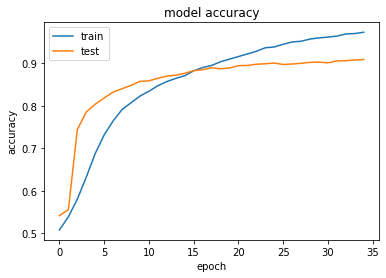

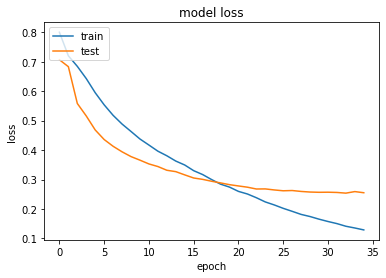

In [38]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [49]:
###### Confusion Matrix ##########
# cm = confusion_matrix(np.argmax(model.predict(X_test),axis=1) , np.argmax(Y_test,axis=1))
# sum = np.sum(cm)
# accuracy = (cm[0][0] + cm[1][1])/sum
# print('-------------Confusion Matrix-----------\n', cm,'\n----------------------------------------')
# print('Test accuracy   ',accuracy)

cm = confusion_matrix(model.predict(X_test)>0.51 , Y_test)
sum = np.sum(cm)
accuracy = (cm[0][0] + cm[1][1])/sum
print('-------------Confusion Matrix-----------\n', cm,'\n----------------------------------------')
print('Test accuracy   ',accuracy)

-------------Confusion Matrix-----------
 [[787  82]
 [ 82 834]] 
----------------------------------------
Test accuracy    0.9081232492997199


In [40]:
model.save("../model")

INFO:tensorflow:Assets written to: ../model/assets


In [41]:
model.predict(X_test) >0.5

array([[ True],
       [False],
       [ True],
       ...,
       [ True],
       [False],
       [False]])

In [42]:
Y_test

array([[0.],
       [1.],
       [1.],
       ...,
       [1.],
       [0.],
       [0.]])